In [ ]:
import os
from google.colab import drive
drive.mount('./MyDrive')

In [ ]:
# access to directory
os.chdir('/content')
print(os.getcwd())

project_path = './MyDrive/MyDrive/NeRF_practice/D-NeRF'
print(os.listdir(project_path))
os.chdir(project_path)
print(os.getcwd())


In [ ]:
!pip install PyMCubes
!pip install trimesh
!pip install lpips
!pip install imageio-ffmpeg

In [ ]:
import time
import torch
import numpy as np
import imageio 
import json
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import numpy as np
from tqdm import tqdm, trange
import mcubes
import trimesh
import math
import lpips

In [ ]:
def config_parser():

    import argparse
    parser = argparse.ArgumentParser()

    parser.add_argument("--expname", type=str, 
                        help='experiment name')
    parser.add_argument("--basedir", type=str, default='./logs/', 
                        help='where to store ckpts and logs')
    parser.add_argument("--datadir", type=str, default='./data/llff/fern', 
                        help='input data directory')

    # training options
    parser.add_argument("--nerf_type", type=str, default="original",
                        help='nerf network type')
    parser.add_argument("--N_iter", type=int, default=500000,
                        help='num training iterations')
    parser.add_argument("--netdepth", type=int, default=8, 
                        help='layers in network')
    parser.add_argument("--netwidth", type=int, default=256, 
                        help='channels per layer')
    parser.add_argument("--netdepth_fine", type=int, default=8, 
                        help='layers in fine network')
    parser.add_argument("--netwidth_fine", type=int, default=256, 
                        help='channels per layer in fine network')
    parser.add_argument("--N_rand", type=int, default=32*32*4, 
                        help='batch size (number of random rays per gradient step)')
    parser.add_argument("--do_half_precision", action='store_true',
                        help='do half precision training and inference')
    parser.add_argument("--lrate", type=float, default=5e-4, 
                        help='learning rate')
    parser.add_argument("--lrate_decay", type=int, default=250, 
                        help='exponential learning rate decay (in 1000 steps)')
    parser.add_argument("--chunk", type=int, default=1024*32, 
                        help='number of rays processed in parallel, decrease if running out of memory')
    parser.add_argument("--netchunk", type=int, default=1024*64, 
                        help='number of pts sent through network in parallel, decrease if running out of memory')
    parser.add_argument("--no_batching", action='store_true', 
                        help='only take random rays from 1 image at a time')
    parser.add_argument("--no_reload", action='store_true', 
                        help='do not reload weights from saved ckpt')
    parser.add_argument("--ft_path", type=str, default=None, 
                        help='specific weights npy file to reload for coarse network')

    # rendering options
    parser.add_argument("--N_samples", type=int, default=64, 
                        help='number of coarse samples per ray')
    parser.add_argument("--not_zero_canonical", action='store_true',
                        help='if set zero time is not the canonic space')
    parser.add_argument("--N_importance", type=int, default=0,
                        help='number of additional fine samples per ray')
    parser.add_argument("--perturb", type=float, default=1.,
                        help='set to 0. for no jitter, 1. for jitter')
    parser.add_argument("--use_viewdirs", action='store_true', 
                        help='use full 5D input instead of 3D')
    parser.add_argument("--i_embed", type=int, default=0, 
                        help='set 0 for default positional encoding, -1 for none')
    parser.add_argument("--multires", type=int, default=10, 
                        help='log2 of max freq for positional encoding (3D location)')
    parser.add_argument("--multires_views", type=int, default=4, 
                        help='log2 of max freq for positional encoding (2D direction)')
    parser.add_argument("--raw_noise_std", type=float, default=0., 
                        help='std dev of noise added to regularize sigma_a output, 1e0 recommended')
    parser.add_argument("--use_two_models_for_fine", action='store_true',
                        help='use two models for fine results')

    parser.add_argument("--render_only", action='store_true', 
                        help='do not optimize, reload weights and render out render_poses path')
    parser.add_argument("--render_test", action='store_true', 
                        help='render the test set instead of render_poses path')
    parser.add_argument("--render_factor", type=int, default=0, 
                        help='downsampling factor to speed up rendering, set 4 or 8 for fast preview')

    # training options
    parser.add_argument("--precrop_iters", type=int, default=0,
                        help='number of steps to train on central crops')
    parser.add_argument("--precrop_iters_time", type=int, default=0,
                        help='number of steps to train on central time')
    parser.add_argument("--precrop_frac", type=float,
                        default=.5, help='fraction of img taken for central crops')
    parser.add_argument("--add_tv_loss", action='store_true',
                        help='evaluate tv loss')
    parser.add_argument("--tv_loss_weight", type=float,
                        default=1.e-4, help='weight of tv loss')

    # dataset options
    parser.add_argument("--dataset_type", type=str, default='llff', 
                        help='options: llff / blender / deepvoxels')
    parser.add_argument("--testskip", type=int, default=2,
                        help='will load 1/N images from test/val sets, useful for large datasets like deepvoxels')

    ## deepvoxels flags
    parser.add_argument("--shape", type=str, default='greek', 
                        help='options : armchair / cube / greek / vase')

    ## blender flags
    parser.add_argument("--white_bkgd", action='store_true', 
                        help='set to render synthetic data on a white bkgd (always use for dvoxels)')
    parser.add_argument("--half_res", action='store_true', 
                        help='load blender synthetic data at 400x400 instead of 800x800')

    ## llff flags
    parser.add_argument("--factor", type=int, default=8, 
                        help='downsample factor for LLFF images')
    parser.add_argument("--no_ndc", action='store_true', 
                        help='do not use normalized device coordinates (set for non-forward facing scenes)')
    parser.add_argument("--lindisp", action='store_true', 
                        help='sampling linearly in disparity rather than depth')
    parser.add_argument("--spherify", action='store_true', 
                        help='set for spherical 360 scenes')
    parser.add_argument("--llffhold", type=int, default=8, 
                        help='will take every 1/N images as LLFF test set, paper uses 8')

    # logging/saving options
    parser.add_argument("--i_print",   type=int, default=100,
                        help='frequency of console printout and metric loggin')
    parser.add_argument("--i_img",     type=int, default=10000,
                        help='frequency of tensorboard image logging')
    parser.add_argument("--i_weights", type=int, default=100000,
                        help='frequency of weight ckpt saving')
    parser.add_argument("--i_testset", type=int, default=200000,
                        help='frequency of testset saving')
    parser.add_argument("--i_video",   type=int, default=200000,
                        help='frequency of render_poses video saving')

    return parser


In [ ]:
parser = config_parser()
args = parser.parse_args(args=[])
args.config = './configs/mutant.txt'

# load config

with open(args.config, 'r') as fp:
    lines = fp.readlines()
    lines = [line.strip() for line in lines]
    lines = [line.split(' = ') for line in lines if len(line)>0]

configs = {}
for line in lines:
    configs[line[0]] = line[1]

print(configs)

args.expname = configs['expname']
args.basedir = configs['basedir']
args.datadir = configs['datadir']
args.dataset_type = configs['dataset_type']

args.nerf_type = configs['nerf_type']
args.no_batching = configs['no_batching']
args.not_zero_canonical = configs['not_zero_canonical']

args.use_viewdirs = configs['use_viewdirs']
args.white_bkgd = configs['white_bkgd']
args.lrate_decay = int(configs['lrate_decay'])

args.N_iter = int(configs['N_iter'])
args.N_samples = int(configs['N_samples'])
args.N_importance = int(configs['N_importance'])
args.N_rand = int(configs['N_rand'])
args.testskip = int(configs['testskip'])

args.precrop_iters = int(configs['precrop_iters'])
args.precrop_iters_time = int(configs['precrop_iters_time'])
args.precrop_frac = float(configs['precrop_frac'])

args.half_res = configs['half_res']
args.do_half_precision = configs['do_half_precision']

args.no_reload = True
print(args)

device = torch.device("cuda")
DEBUG=False
print(device)

torch.set_default_tensor_type('torch.cuda.FloatTensor')

## Visualize dataset

In [ ]:
print(render_poses.shape)
print(images.shape)
print(times)

# data practice
_datadir = './data/mutant'

with open(os.path.join(_datadir, 'transforms_test.json'), 'r') as fp:
    meta = json.load(fp)


print(str(meta)[:300])

_frames = meta['frames']
_frame = _frames[0]
print(_frame)

_fname = os.path.join(_datadir, _frame['file_path']+'.png')
print(_fname)

img = imageio.imread(_fname)
print(img.shape) # 4 channel rgba

fig, axis = plt.subplots(1, 10, figsize=(30,300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame['file_path']+'.png')
    img = imageio.imread(_fname)
    axis[i].imshow(img)

In [ ]:
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()

def rodrigues_mat_to_rot(R):
  eps =1e-16
  trc = np.trace(R)
  trc2 = (trc - 1.)/ 2.
  #sinacostrc2 = np.sqrt(1 - trc2 * trc2)
  s = np.array([R[2, 1] - R[1, 2], R[0, 2] - R[2, 0], R[1, 0] - R[0, 1]])
  if (1 - trc2 * trc2) >= eps:
    tHeta = np.arccos(trc2)
    tHetaf = tHeta / (2 * (np.sin(tHeta)))
  else:
    tHeta = np.real(np.arccos(trc2))
    tHetaf = 0.5 / (1 - tHeta / 6)
  omega = tHetaf * s
  return omega

def rodrigues_rot_to_mat(r):
  wx,wy,wz = r
  theta = np.sqrt(wx * wx + wy * wy + wz * wz)
  a = np.cos(theta)
  b = (1 - np.cos(theta)) / (theta*theta)
  c = np.sin(theta) / theta
  R = np.zeros([3,3])
  R[0, 0] = a + b * (wx * wx)
  R[0, 1] = b * wx * wy - c * wz
  R[0, 2] = b * wx * wz + c * wy
  R[1, 0] = b * wx * wy + c * wz
  R[1, 1] = a + b * (wy * wy)
  R[1, 2] = b * wy * wz - c * wx
  R[2, 0] = b * wx * wz - c * wy
  R[2, 1] = b * wz * wy + c * wx
  R[2, 2] = a + b * (wz * wz)
  return R


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w
    return c2w


def load_blender_data(basedir, half_res=False, testskip=1):
    splits = ['train', 'val', 'test']
    metas = {}
    for s in splits:
        with open(os.path.join(basedir, 'transforms_{}.json'.format(s)), 'r') as fp:
            metas[s] = json.load(fp)

    all_imgs = []
    all_poses = []
    all_times = []
    counts = [0]
    for s in splits:
        meta = metas[s]

        imgs = []
        poses = []
        times = []
        # if s=='train' or testskip==0:
        #     skip = 2  # if you remove/change this 2, also change the /2 in the times vector
        # else:
        skip = testskip
            
        for t, frame in enumerate(meta['frames'][::skip]):
            fname = os.path.join(basedir, frame['file_path'] + '.png')
            imgs.append(imageio.imread(fname))
            poses.append(np.array(frame['transform_matrix']))
            cur_time = frame['time'] if 'time' in frame else float(t) / (len(meta['frames'][::skip])-1)
            times.append(cur_time)

        assert times[0] == 0, "Time must start at 0"

        imgs = (np.array(imgs) / 255.).astype(np.float32)  # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32)
        times = np.array(times).astype(np.float32)
        counts.append(counts[-1] + imgs.shape[0])
        all_imgs.append(imgs)
        all_poses.append(poses)
        all_times.append(times)
    
    i_split = [np.arange(counts[i], counts[i+1]) for i in range(3)]
    
    imgs = np.concatenate(all_imgs, 0)
    poses = np.concatenate(all_poses, 0)
    times = np.concatenate(all_times, 0)
    
    H, W = imgs[0].shape[:2]
    camera_angle_x = float(meta['camera_angle_x'])
    focal = .5 * W / np.tan(.5 * camera_angle_x)

    if os.path.exists(os.path.join(basedir, 'transforms_{}.json'.format('render'))):
        with open(os.path.join(basedir, 'transforms_{}.json'.format('render')), 'r') as fp:
            meta = json.load(fp)
        render_poses = []
        for frame in meta['frames']:
            render_poses.append(np.array(frame['transform_matrix']))
        render_poses = np.array(render_poses).astype(np.float32)
    else:
        render_poses = torch.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)
    render_times = torch.linspace(0., 1., render_poses.shape[0])
    
    if half_res:
        H = H//2
        W = W//2
        focal = focal/2.

        imgs_half_res = np.zeros((imgs.shape[0], H, W, 4))
        for i, img in enumerate(imgs):
            imgs_half_res[i] = cv2.resize(img, (H, W), interpolation=cv2.INTER_AREA)
        imgs = imgs_half_res
        # imgs = tf.image.resize_area(imgs, [400, 400]).numpy()

        
    return imgs, poses, times, render_poses, render_times, [H, W, focal], i_split

In [ ]:
images, poses, times, render_poses, render_times, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)

In [ ]:
# Positional encoding (section 5.1)
class Embedder:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.create_embedding_fn()
        
    def create_embedding_fn(self):
        embed_fns = []
        d = self.kwargs['input_dims']
        out_dim = 0
        if self.kwargs['include_input']:
            embed_fns.append(lambda x : x)
            out_dim += d
            
        max_freq = self.kwargs['max_freq_log2']
        N_freqs = self.kwargs['num_freqs']
        
        if self.kwargs['log_sampling']:
            freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)
        else:
            freq_bands = torch.linspace(2.**0., 2.**max_freq, steps=N_freqs)
            
        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(x * freq))
                out_dim += d
                    
        self.embed_fns = embed_fns
        self.out_dim = out_dim
        
    def embed(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], -1)


def get_embedder(multires, input_dims, i=0):
    if i == -1:
        return nn.Identity(), input_dims
    
    embed_kwargs = {
                'include_input' : True,
                'input_dims' : input_dims,
                'max_freq_log2' : multires-1,
                'num_freqs' : multires,
                'log_sampling' : True,
                'periodic_fns' : [torch.sin, torch.cos],
    }
    
    embedder_obj = Embedder(**embed_kwargs)
    embed = lambda x, eo=embedder_obj : eo.embed(x)
    return embed, embedder_obj.out_dim


# Model
class DirectTemporalNeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, input_ch_time=1, output_ch=4, skips=[4],
                 use_viewdirs=False, memory=[], embed_fn=None, zero_canonical=True):
        super(DirectTemporalNeRF, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.input_ch_time = input_ch_time
        self.skips = skips
        self.use_viewdirs = use_viewdirs
        self.memory = memory
        self.embed_fn = embed_fn
        self.zero_canonical = zero_canonical

        self._occ = NeRFOriginal(D=D, W=W, input_ch=input_ch, input_ch_views=input_ch_views,
                                 input_ch_time=input_ch_time, output_ch=output_ch, skips=skips,
                                 use_viewdirs=use_viewdirs, memory=memory, embed_fn=embed_fn, output_color_ch=3)
        self._time, self._time_out = self.create_time_net()

    def create_time_net(self):
        layers = [nn.Linear(self.input_ch + self.input_ch_time, self.W)]
        for i in range(self.D - 1):
            if i in self.memory:
                raise NotImplementedError
            else:
                layer = nn.Linear

            in_channels = self.W
            if i in self.skips:
                in_channels += self.input_ch

            layers += [layer(in_channels, self.W)]
        return nn.ModuleList(layers), nn.Linear(self.W, 3)

    def query_time(self, new_pts, t, net, net_final):
        h = torch.cat([new_pts, t], dim=-1)
        for i, l in enumerate(net):
            h = net[i](h)
            h = F.relu(h)
            if i in self.skips:
                h = torch.cat([new_pts, h], -1)

        return net_final(h)

    def forward(self, x, ts):
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1)
        t = ts[0]

        assert len(torch.unique(t[:, :1])) == 1, "Only accepts all points from same time"
        cur_time = t[0, 0]
        if cur_time == 0. and self.zero_canonical:
            dx = torch.zeros_like(input_pts[:, :3])
        else:
            dx = self.query_time(input_pts, t, self._time, self._time_out)
            input_pts_orig = input_pts[:, :3]
            input_pts = self.embed_fn(input_pts_orig + dx)
        out, _ = self._occ(torch.cat([input_pts, input_views], dim=-1), t)
        return out, dx


class NeRF:
    @staticmethod
    def get_by_name(type,  *args, **kwargs):
        print ("NeRF type selected: %s" % type)

        if type == "original":
            model = NeRFOriginal(*args, **kwargs)
        elif type == "direct_temporal":
            model = DirectTemporalNeRF(*args, **kwargs)
        else:
            raise ValueError("Type %s not recognized." % type)
        return model

class NeRFOriginal(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, input_ch_time=1, output_ch=4, skips=[4],
                 use_viewdirs=False, memory=[], embed_fn=None, output_color_ch=3, zero_canonical=True):
        super(NeRFOriginal, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skips = skips
        self.use_viewdirs = use_viewdirs

        # self.pts_linears = nn.ModuleList(
        #     [nn.Linear(input_ch, W)] +
        #     [nn.Linear(W, W) if i not in self.skips else nn.Linear(W + input_ch, W) for i in range(D-1)])

        layers = [nn.Linear(input_ch, W)]
        for i in range(D - 1):
            if i in memory:
                raise NotImplementedError
            else:
                layer = nn.Linear

            in_channels = W
            if i in self.skips:
                in_channels += input_ch

            layers += [layer(in_channels, W)]

        self.pts_linears = nn.ModuleList(layers)

        ### Implementation according to the official code release (https://github.com/bmild/nerf/blob/master/run_nerf_helpers.py#L104-L105)
        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views + W, W//2)])

        ### Implementation according to the paper
        # self.views_linears = nn.ModuleList(
        #     [nn.Linear(input_ch_views + W, W//2)] + [nn.Linear(W//2, W//2) for i in range(D//2)])

        if use_viewdirs:
            self.feature_linear = nn.Linear(W, W)
            self.alpha_linear = nn.Linear(W, 1)
            self.rgb_linear = nn.Linear(W//2, output_color_ch)
        else:
            self.output_linear = nn.Linear(W, output_ch)

    def forward(self, x, ts):
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1)
        h = input_pts
        for i, l in enumerate(self.pts_linears):
            h = self.pts_linears[i](h)
            h = F.relu(h)
            if i in self.skips:
                h = torch.cat([input_pts, h], -1)

        if self.use_viewdirs:
            alpha = self.alpha_linear(h)
            feature = self.feature_linear(h)
            h = torch.cat([feature, input_views], -1)

            for i, l in enumerate(self.views_linears):
                h = self.views_linears[i](h)
                h = F.relu(h)

            rgb = self.rgb_linear(h)
            outputs = torch.cat([rgb, alpha], -1)
        else:
            outputs = self.output_linear(h)

        return outputs, torch.zeros_like(input_pts[:, :3])

    def load_weights_from_keras(self, weights):
        assert self.use_viewdirs, "Not implemented if use_viewdirs=False"

        # Load pts_linears
        for i in range(self.D):
            idx_pts_linears = 2 * i
            self.pts_linears[i].weight.data = torch.from_numpy(np.transpose(weights[idx_pts_linears]))
            self.pts_linears[i].bias.data = torch.from_numpy(np.transpose(weights[idx_pts_linears+1]))

        # Load feature_linear
        idx_feature_linear = 2 * self.D
        self.feature_linear.weight.data = torch.from_numpy(np.transpose(weights[idx_feature_linear]))
        self.feature_linear.bias.data = torch.from_numpy(np.transpose(weights[idx_feature_linear+1]))

        # Load views_linears
        idx_views_linears = 2 * self.D + 2
        self.views_linears[0].weight.data = torch.from_numpy(np.transpose(weights[idx_views_linears]))
        self.views_linears[0].bias.data = torch.from_numpy(np.transpose(weights[idx_views_linears+1]))

        # Load rgb_linear
        idx_rbg_linear = 2 * self.D + 4
        self.rgb_linear.weight.data = torch.from_numpy(np.transpose(weights[idx_rbg_linear]))
        self.rgb_linear.bias.data = torch.from_numpy(np.transpose(weights[idx_rbg_linear+1]))

        # Load alpha_linear
        idx_alpha_linear = 2 * self.D + 6
        self.alpha_linear.weight.data = torch.from_numpy(np.transpose(weights[idx_alpha_linear]))
        self.alpha_linear.bias.data = torch.from_numpy(np.transpose(weights[idx_alpha_linear+1]))


def hsv_to_rgb(h, s, v):
    '''
    h,s,v in range [0,1]
    '''
    hi = torch.floor(h * 6)
    f = h * 6. - hi
    p = v * (1. - s)
    q = v * (1. - f * s)
    t = v * (1. - (1. - f) * s)

    rgb = torch.cat([hi, hi, hi], -1) % 6
    rgb[rgb == 0] = torch.cat((v, t, p), -1)[rgb == 0]
    rgb[rgb == 1] = torch.cat((q, v, p), -1)[rgb == 1]
    rgb[rgb == 2] = torch.cat((p, v, t), -1)[rgb == 2]
    rgb[rgb == 3] = torch.cat((p, q, v), -1)[rgb == 3]
    rgb[rgb == 4] = torch.cat((t, p, v), -1)[rgb == 4]
    rgb[rgb == 5] = torch.cat((v, p, q), -1)[rgb == 5]
    return rgb


# Ray helpers
def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()
    dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = c2w[:3,-1].expand(rays_d.shape)
    return rays_o, rays_d


def get_rays_np(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    return rays_o, rays_d


def ndc_rays(H, W, focal, near, rays_o, rays_d):
    # Shift ray origins to near plane
    t = -(near + rays_o[...,2]) / rays_d[...,2]
    rays_o = rays_o + t[...,None] * rays_d
    
    # Projection
    o0 = -1./(W/(2.*focal)) * rays_o[...,0] / rays_o[...,2]
    o1 = -1./(H/(2.*focal)) * rays_o[...,1] / rays_o[...,2]
    o2 = 1. + 2. * near / rays_o[...,2]

    d0 = -1./(W/(2.*focal)) * (rays_d[...,0]/rays_d[...,2] - rays_o[...,0]/rays_o[...,2])
    d1 = -1./(H/(2.*focal)) * (rays_d[...,1]/rays_d[...,2] - rays_o[...,1]/rays_o[...,2])
    d2 = -2. * near / rays_o[...,2]
    
    rays_o = torch.stack([o0,o1,o2], -1)
    rays_d = torch.stack([d0,d1,d2], -1)
    
    return rays_o, rays_d


# Hierarchical sampling (section 5.2)
def sample_pdf(bins, weights, N_samples, det=False, pytest=False):
    # Get pdf
    weights = weights + 1e-5 # prevent nans
    pdf = weights / torch.sum(weights, -1, keepdim=True)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], -1)  # (batch, len(bins))

    # Take uniform samples
    if det:
        u = torch.linspace(0., 1., steps=N_samples)
        u = u.expand(list(cdf.shape[:-1]) + [N_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples])

    # Pytest, overwrite u with numpy's fixed random numbers
    if pytest:
        np.random.seed(0)
        new_shape = list(cdf.shape[:-1]) + [N_samples]
        if det:
            u = np.linspace(0., 1., N_samples)
            u = np.broadcast_to(u, new_shape)
        else:
            u = np.random.rand(*new_shape)
        u = torch.Tensor(u)

    # Invert CDF
    u = u.contiguous()
    inds = torch.searchsorted(cdf, u, side='right')
    below = torch.max(torch.zeros_like(inds-1), inds-1)
    above = torch.min((cdf.shape[-1]-1) * torch.ones_like(inds), inds)
    inds_g = torch.stack([below, above], -1)  # (batch, N_samples, 2)

    # cdf_g = tf.gather(cdf, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    # bins_g = tf.gather(bins, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]]
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)

    denom = (cdf_g[...,1]-cdf_g[...,0])
    denom = torch.where(denom<1e-5, torch.ones_like(denom), denom)
    t = (u-cdf_g[...,0])/denom
    samples = bins_g[...,0] + t * (bins_g[...,1]-bins_g[...,0])

    return samples

In [ ]:
# Misc
img2mse = lambda x, y : torch.mean((x - y) ** 2)
mse2psnr = lambda x : -10. * torch.log(x) / torch.log(torch.Tensor([10.]))
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)

In [ ]:
DEBUG = False


def batchify(fn, chunk):
    """Constructs a version of 'fn' that applies to smaller batches.
    """
    if chunk is None:
        return fn
    def ret(inputs_pos, inputs_time):
        num_batches = inputs_pos.shape[0]

        out_list = []
        dx_list = []
        for i in range(0, num_batches, chunk):
            out, dx = fn(inputs_pos[i:i+chunk], [inputs_time[0][i:i+chunk], inputs_time[1][i:i+chunk]])
            out_list += [out]
            dx_list += [dx]
        return torch.cat(out_list, 0), torch.cat(dx_list, 0)
    return ret


def run_network(inputs, viewdirs, frame_time, fn, embed_fn, embeddirs_fn, embedtime_fn, netchunk=1024*64,
                embd_time_discr=True):
    """Prepares inputs and applies network 'fn'.
    inputs: N_rays x N_points_per_ray x 3
    viewdirs: N_rays x 3
    frame_time: N_rays x 1
    """
    assert len(torch.unique(frame_time)) == 1, "Only accepts all points from same time"
    cur_time = torch.unique(frame_time)[0]

    # embed position
    inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]])
    embedded = embed_fn(inputs_flat)

    # embed time
    if embd_time_discr:
        B, N, _ = inputs.shape
        input_frame_time = frame_time[:, None].expand([B, N, 1])
        input_frame_time_flat = torch.reshape(input_frame_time, [-1, 1])
        embedded_time = embedtime_fn(input_frame_time_flat)
        embedded_times = [embedded_time, embedded_time]

    else:
        assert NotImplementedError

    # embed views
    if viewdirs is not None:
        input_dirs = viewdirs[:,None].expand(inputs.shape)
        input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]])
        embedded_dirs = embeddirs_fn(input_dirs_flat)
        embedded = torch.cat([embedded, embedded_dirs], -1)

    outputs_flat, position_delta_flat = batchify(fn, netchunk)(embedded, embedded_times)
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])
    position_delta = torch.reshape(position_delta_flat, list(inputs.shape[:-1]) + [position_delta_flat.shape[-1]])
    return outputs, position_delta


def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """Render rays in smaller minibatches to avoid OOM.
    """
    all_ret = {}
    for i in range(0, rays_flat.shape[0], chunk):
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)
        for k in ret:
            if k not in all_ret:
                all_ret[k] = []
            all_ret[k].append(ret[k])

    all_ret = {k : torch.cat(all_ret[k], 0) for k in all_ret}
    return all_ret


def render(H, W, focal, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=1., frame_time=None,
                  use_viewdirs=False, c2w_staticcam=None,
                  **kwargs):
    """Render rays
    Args:
      H: int. Height of image in pixels.
      W: int. Width of image in pixels.
      focal: float. Focal length of pinhole camera.
      chunk: int. Maximum number of rays to process simultaneously. Used to
        control maximum memory usage. Does not affect final results.
      rays: array of shape [2, batch_size, 3]. Ray origin and direction for
        each example in batch.
      c2w: array of shape [3, 4]. Camera-to-world transformation matrix.
      ndc: bool. If True, represent ray origin, direction in NDC coordinates.
      near: float or array of shape [batch_size]. Nearest distance for a ray.
      far: float or array of shape [batch_size]. Farthest distance for a ray.
      use_viewdirs: bool. If True, use viewing direction of a point in space in model.
      c2w_staticcam: array of shape [3, 4]. If not None, use this transformation matrix for 
       camera while using other c2w argument for viewing directions.
    Returns:
      rgb_map: [batch_size, 3]. Predicted RGB values for rays.
      disp_map: [batch_size]. Disparity map. Inverse of depth.
      acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
      extras: dict with everything returned by render_rays().
    """
    if c2w is not None:
        # special case to render full image
        rays_o, rays_d = get_rays(H, W, focal, c2w)
    else:
        # use provided ray batch
        rays_o, rays_d = rays

    if use_viewdirs:
        # provide ray directions as input
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # special case to visualize effect of viewdirs
            rays_o, rays_d = get_rays(H, W, focal, c2w_staticcam)
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
        viewdirs = torch.reshape(viewdirs, [-1,3]).float()

    sh = rays_d.shape # [..., 3]
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(H, W, focal, 1., rays_o, rays_d)

    # Create ray batch
    rays_o = torch.reshape(rays_o, [-1,3]).float()
    rays_d = torch.reshape(rays_d, [-1,3]).float()

    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])
    frame_time = frame_time * torch.ones_like(rays_d[...,:1])

    rays = torch.cat([rays_o, rays_d, near, far, frame_time], -1)
    if use_viewdirs:

        rays = torch.cat([rays, viewdirs], -1)

    # Render and reshape
    all_ret = batchify_rays(rays, chunk, **kwargs)
    for k in all_ret:
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = torch.reshape(all_ret[k], k_sh)

    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]


def render_path(render_poses, render_times, hwf, chunk, render_kwargs, gt_imgs=None, savedir=None,
                render_factor=0, save_also_gt=False, i_offset=0):

    H, W, focal = hwf

    if render_factor!=0:
        # Render downsampled for speed
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    if savedir is not None:
        save_dir_estim = os.path.join(savedir, "estim")
        save_dir_gt = os.path.join(savedir, "gt")
        if not os.path.exists(save_dir_estim):
            os.makedirs(save_dir_estim)
        if save_also_gt and not os.path.exists(save_dir_gt):
            os.makedirs(save_dir_gt)

    rgbs = []
    disps = []
    accs = []

    for i, (c2w, frame_time) in enumerate(zip(tqdm(render_poses), render_times)):
        rgb, disp, acc, _ = render(H, W, focal, chunk=chunk, c2w=c2w[:3,:4], frame_time=frame_time, **render_kwargs)
        rgbs.append(rgb.cpu().numpy())
        disps.append(disp.cpu().numpy())
        accs.append(acc.cpu().numpy())

        if savedir is not None:
            rgb8_estim = to8b(rgbs[-1])
            filename = os.path.join(save_dir_estim, '{:03d}.png'.format(i+i_offset))
            imageio.imwrite(filename, rgb8_estim)
            if save_also_gt:
                rgb8_gt = to8b(gt_imgs[i])
                filename = os.path.join(save_dir_gt, '{:03d}.png'.format(i+i_offset))
                imageio.imwrite(filename, rgb8_gt)

    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)
    accs = np.stack(accs, 0)

    return rgbs, disps, accs


def create_nerf(args):
    """Instantiate NeRF's MLP model.
    """
    embed_fn, input_ch = get_embedder(args.multires, 3, args.i_embed)
    embedtime_fn, input_ch_time = get_embedder(args.multires, 1, args.i_embed) # multires: 10, i_embed: 0(pe)

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(args.multires_views, 3, args.i_embed)

    output_ch = 5 if args.N_importance > 0 else 4
    skips = [4]
    model = NeRF.get_by_name(args.nerf_type, D=args.netdepth, W=args.netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, input_ch_time=input_ch_time,
                 use_viewdirs=args.use_viewdirs, embed_fn=embed_fn,
                 zero_canonical=not args.not_zero_canonical).to(device)
    grad_vars = list(model.parameters())

    model_fine = None
    if args.use_two_models_for_fine:
        model_fine = NeRF.get_by_name(args.nerf_type, D=args.netdepth_fine, W=args.netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, input_ch_time=input_ch_time,
                          use_viewdirs=args.use_viewdirs, embed_fn=embed_fn,
                          zero_canonical=not args.not_zero_canonical).to(device)
        grad_vars += list(model_fine.parameters())

    network_query_fn = lambda inputs, viewdirs, ts, network_fn : run_network(inputs, viewdirs, ts, network_fn,
                                                                embed_fn=embed_fn,
                                                                embeddirs_fn=embeddirs_fn,
                                                                embedtime_fn=embedtime_fn,
                                                                netchunk=args.netchunk,
                                                                embd_time_discr=args.nerf_type!="temporal")

    # Create optimizer
    optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999))

    '''
    if args.do_half_precision:
        print("Run model at half precision")
        if model_fine is not None:
            [model, model_fine], optimizers = amp.initialize([model, model_fine], optimizer, opt_level='O1')
        else:
            model, optimizers = amp.initialize(model, optimizer, opt_level='O1')
    '''

    start = 0
    basedir = args.basedir
    expname = args.expname

    ##########################

    # Load checkpoints
    if args.ft_path is not None and args.ft_path!='None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict'])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict'])
        print(f'Loaded from {ckpt_path}')


    ##########################

    render_kwargs_train = {
        'network_query_fn' : network_query_fn,
        'perturb' : args.perturb,
        'N_importance' : args.N_importance,
        'network_fine': model_fine,
        'N_samples' : args.N_samples,
        'network_fn' : model,
        'use_viewdirs' : args.use_viewdirs,
        'white_bkgd' : args.white_bkgd,
        'raw_noise_std' : args.raw_noise_std,
        'use_two_models_for_fine' : args.use_two_models_for_fine,
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.

    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer


def raw2outputs(raw, z_vals, rays_d, raw_noise_std=0, white_bkgd=False, pytest=False):
    """Transforms model's predictions to semantically meaningful values.
    Args:
        raw: [num_rays, num_samples along ray, 4]. Prediction from model.
        z_vals: [num_rays, num_samples along ray]. Integration time.
        rays_d: [num_rays, 3]. Direction of each ray.
    Returns:
        rgb_map: [num_rays, 3]. Estimated RGB color of a ray.
        disp_map: [num_rays]. Disparity map. Inverse of depth map.
        acc_map: [num_rays]. Sum of weights along each ray.
        weights: [num_rays, num_samples]. Weights assigned to each sampled color.
        depth_map: [num_rays]. Estimated distance to object.
    """
    raw2alpha = lambda raw, dists, act_fn=F.relu: 1.-torch.exp(-act_fn(raw)*dists)

    dists = z_vals[...,1:] - z_vals[...,:-1]
    dists = torch.cat([dists, torch.Tensor([1e10]).expand(dists[...,:1].shape)], -1)  # [N_rays, N_samples]

    dists = dists * torch.norm(rays_d[...,None,:], dim=-1)

    rgb = torch.sigmoid(raw[...,:3])  # [N_rays, N_samples, 3]
    noise = 0.
    if raw_noise_std > 0.:
        noise = torch.randn(raw[...,3].shape) * raw_noise_std

        # Overwrite randomly sampled data if pytest
        if pytest:
            np.random.seed(0)
            noise = np.random.rand(*list(raw[...,3].shape)) * raw_noise_std
            noise = torch.Tensor(noise)

    alpha = raw2alpha(raw[...,3] + noise, dists)  # [N_rays, N_samples]
    # weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)), 1.-alpha + 1e-10], -1), -1)[:, :-1]
    rgb_map = torch.sum(weights[...,None] * rgb, -2)  # [N_rays, 3]

    depth_map = torch.sum(weights * z_vals, -1)
    disp_map = 1./torch.max(1e-10 * torch.ones_like(depth_map), depth_map / torch.sum(weights, -1))
    acc_map = torch.sum(weights, -1)

    if white_bkgd:
        rgb_map = rgb_map + (1.-acc_map[...,None])
        # rgb_map = rgb_map + torch.cat([acc_map[..., None] * 0, acc_map[..., None] * 0, (1. - acc_map[..., None])], -1)

    return rgb_map, disp_map, acc_map, weights, depth_map


def render_rays(ray_batch,
                network_fn,
                network_query_fn,
                N_samples,
                retraw=False,
                lindisp=False,
                perturb=0.,
                N_importance=0,
                network_fine=None,
                white_bkgd=False,
                raw_noise_std=0.,
                verbose=False,
                pytest=False,
                z_vals=None,
                use_two_models_for_fine=False):
    """Volumetric rendering.
    Args:
      ray_batch: array of shape [batch_size, ...]. All information necessary
        for sampling along a ray, including: ray origin, ray direction, min
        dist, max dist, and unit-magnitude viewing direction.
      network_fn: function. Model for predicting RGB and density at each point
        in space.
      network_query_fn: function used for passing queries to network_fn.
      N_samples: int. Number of different times to sample along each ray.
      retraw: bool. If True, include model's raw, unprocessed predictions.
      lindisp: bool. If True, sample linearly in inverse depth rather than in depth.
      perturb: float, 0 or 1. If non-zero, each ray is sampled at stratified
        random points in time.
      N_importance: int. Number of additional times to sample along each ray.
        These samples are only passed to network_fine.
      network_fine: "fine" network with same spec as network_fn.
      white_bkgd: bool. If True, assume a white background.
      raw_noise_std: ...
      verbose: bool. If True, print more debugging info.
    Returns:
      rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
      disp_map: [num_rays]. Disparity map. 1 / depth.
      acc_map: [num_rays]. Accumulated opacity along each ray. Comes from fine model.
      raw: [num_rays, num_samples, 4]. Raw predictions from model.
      rgb0: See rgb_map. Output for coarse model.
      disp0: See disp_map. Output for coarse model.
      acc0: See acc_map. Output for coarse model.
      z_std: [num_rays]. Standard deviation of distances along ray for each
        sample.
    """

    N_rays = ray_batch.shape[0]
    rays_o, rays_d = ray_batch[:,0:3], ray_batch[:,3:6] # [N_rays, 3] each
    viewdirs = ray_batch[:,-3:] if ray_batch.shape[-1] > 9 else None
    bounds = torch.reshape(ray_batch[...,6:9], [-1,1,3])
    near, far, frame_time = bounds[...,0], bounds[...,1], bounds[...,2] # [-1,1]
    z_samples = None
    rgb_map_0, disp_map_0, acc_map_0, position_delta_0 = None, None, None, None

    if z_vals is None:
        t_vals = torch.linspace(0., 1., steps=N_samples)
        if not lindisp:
            z_vals = near * (1.-t_vals) + far * (t_vals)
        else:
            z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

        z_vals = z_vals.expand([N_rays, N_samples])

        if perturb > 0.:
            # get intervals between samples
            mids = .5 * (z_vals[...,1:] + z_vals[...,:-1])
            upper = torch.cat([mids, z_vals[...,-1:]], -1)
            lower = torch.cat([z_vals[...,:1], mids], -1)
            # stratified samples in those intervals
            t_rand = torch.rand(z_vals.shape)

            # Pytest, overwrite u with numpy's fixed random numbers
            if pytest:
                np.random.seed(0)
                t_rand = np.random.rand(*list(z_vals.shape))
                t_rand = torch.Tensor(t_rand)

            z_vals = lower + (upper - lower) * t_rand

        pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]


        if N_importance <= 0:
            raw, position_delta = network_query_fn(pts, viewdirs, frame_time, network_fn)
            rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

        else:
            if use_two_models_for_fine:
                raw, position_delta_0 = network_query_fn(pts, viewdirs, frame_time, network_fn)
                rgb_map_0, disp_map_0, acc_map_0, weights, _ = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

            else:
                with torch.no_grad():
                    raw, _ = network_query_fn(pts, viewdirs, frame_time, network_fn)
                    _, _, _, weights, _ = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

            z_vals_mid = .5 * (z_vals[...,1:] + z_vals[...,:-1])
            z_samples = sample_pdf(z_vals_mid, weights[...,1:-1], N_importance, det=(perturb==0.), pytest=pytest)
            z_samples = z_samples.detach()
            z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1)

    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]
    run_fn = network_fn if network_fine is None else network_fine
    raw, position_delta = network_query_fn(pts, viewdirs, frame_time, run_fn)
    rgb_map, disp_map, acc_map, weights, _ = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

    ret = {'rgb_map' : rgb_map, 'disp_map' : disp_map, 'acc_map' : acc_map, 'z_vals' : z_vals,
           'position_delta' : position_delta}
    if retraw:
        ret['raw'] = raw
    if N_importance > 0:
        if rgb_map_0 is not None:
            ret['rgb0'] = rgb_map_0
        if disp_map_0 is not None:
            ret['disp0'] = disp_map_0
        if acc_map_0 is not None:
            ret['acc0'] = acc_map_0
        if position_delta_0 is not None:
            ret['position_delta_0'] = position_delta_0
        if z_samples is not None:
            ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    for k in ret:
        if (torch.isnan(ret[k]).any() or torch.isinf(ret[k]).any()) and DEBUG:
            print(f"! [Numerical Error] {k} contains nan or inf.")

    return ret

In [ ]:
def train(args):

    # Load data

    if args.dataset_type == 'blender':
        images, poses, times, render_poses, render_times, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
        print('Loaded blender', images.shape, render_poses.shape, hwf, args.datadir)
        i_train, i_val, i_test = i_split

        near = 2.
        far = 6.

        if args.white_bkgd:
            images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
        else:
            images = images[...,:3]

        # images = [rgb2hsv(img) for img in images]

    else:
        print('Unknown dataset type', args.dataset_type, 'exiting')
        return

    min_time, max_time = times[i_train[0]], times[i_train[-1]]
    assert min_time == 0., "time must start at 0"
    assert max_time == 1., "max time must be 1"

    # Cast intrinsics to right types
    H, W, focal = hwf
    H, W = int(H), int(W)
    hwf = [H, W, focal]

    if args.render_test:
        render_poses = np.array(poses[i_test])
        render_times = np.array(times[i_test])

    # Create log dir and copy the config file
    basedir = args.basedir
    expname = args.expname
    os.makedirs(os.path.join(basedir, expname), exist_ok=True)
    f = os.path.join(basedir, expname, 'args.txt')
    with open(f, 'w') as file:
        for arg in sorted(vars(args)):
            attr = getattr(args, arg)
            file.write('{} = {}\n'.format(arg, attr))
    if args.config is not None:
        f = os.path.join(basedir, expname, 'config.txt')
        with open(f, 'w') as file:
            file.write(open(args.config, 'r').read())

    # Create nerf model
    render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_nerf(args)
    global_step = start

    bds_dict = {
        'near' : near,
        'far' : far,
    }
    render_kwargs_train.update(bds_dict)
    render_kwargs_test.update(bds_dict)

    # Move testing data to GPU
    render_poses = torch.Tensor(render_poses).to(device)
    render_times = torch.Tensor(render_times).to(device)

    # Short circuit if only rendering out from trained model
    if args.render_only:
        print('RENDER ONLY')
        with torch.no_grad():
            if args.render_test:
                # render_test switches to test poses
                images = images[i_test]
            else:
                # Default is smoother render_poses path
                images = None

            testsavedir = os.path.join(basedir, expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
            os.makedirs(testsavedir, exist_ok=True)
            print('test poses shape', render_poses.shape)

            rgbs, _, _ = render_path(render_poses, render_times, hwf, args.chunk, render_kwargs_test, gt_imgs=images,
                                  savedir=testsavedir, render_factor=args.render_factor, save_also_gt=False)
            print('Done rendering', testsavedir)
            imageio.mimwrite(os.path.join(testsavedir, 'video.mp4'), to8b(rgbs), fps=10, quality=8)

            return

    # Prepare raybatch tensor if batching random rays
    N_rand = args.N_rand
    use_batching = not args.no_batching
    if use_batching:
        # For random ray batching
        print('get rays')
        rays = np.stack([get_rays_np(H, W, focal, p) for p in poses[:,:3,:4]], 0) # [N, ro+rd, H, W, 3]
        print('done, concats')
        rays_rgb = np.concatenate([rays, images[:,None]], 1) # [N, ro+rd+rgb, H, W, 3]
        rays_rgb = np.transpose(rays_rgb, [0,2,3,1,4]) # [N, H, W, ro+rd+rgb, 3]
        rays_rgb = np.stack([rays_rgb[i] for i in i_train], 0) # train images only
        rays_rgb = np.reshape(rays_rgb, [-1,3,3]) # [(N-1)*H*W, ro+rd+rgb, 3]
        rays_rgb = rays_rgb.astype(np.float32)
        print('shuffle rays')
        np.random.shuffle(rays_rgb)

        print('done')
        i_batch = 0

    # Move training data to GPU
    images = torch.Tensor(images).to(device)
    poses = torch.Tensor(poses).to(device)
    times = torch.Tensor(times).to(device)
    if use_batching:
        rays_rgb = torch.Tensor(rays_rgb).to(device)

    psnrs = []
    iternums = []
    N_iters = args.N_iter + 1
    print('Begin')

    # Summary writers
    #writer = SummaryWriter(os.path.join(basedir, 'summaries', expname))
    
    start = start
    for i in trange(start, N_iters):
        time0 = time.time()

        # Sample random ray batch
        if use_batching: # False 
            raise NotImplementedError("Time not implemented")

            # Random over all images
            batch = rays_rgb[i_batch:i_batch+N_rand] # [B, 2+1, 3*?]
            batch = torch.transpose(batch, 0, 1)
            batch_rays, target_s = batch[:2], batch[2]

            i_batch += N_rand
            if i_batch >= rays_rgb.shape[0]:
                print("Shuffle data after an epoch!")
                rand_idx = torch.randperm(rays_rgb.shape[0])
                rays_rgb = rays_rgb[rand_idx]
                i_batch = 0

        else:
            # Random from one image
            if i >= args.precrop_iters_time:
                img_i = np.random.choice(i_train)
            else:
                skip_factor = i / float(args.precrop_iters_time) * len(i_train)
                max_sample = max(int(skip_factor), 3)
                img_i = np.random.choice(i_train[:max_sample])

            target = images[img_i]
            pose = poses[img_i, :3, :4]
            frame_time = times[img_i]

            if N_rand is not None:
                rays_o, rays_d = get_rays(H, W, focal, torch.Tensor(pose))  # (H, W, 3), (H, W, 3)

                if i < args.precrop_iters:
                    dH = int(H//2 * args.precrop_frac)
                    dW = int(W//2 * args.precrop_frac)
                    coords = torch.stack(
                        torch.meshgrid(
                            torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH), 
                            torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)
                        ), -1)
                    if i == start:
                        print(f"[Config] Center cropping of size {2*dH} x {2*dW} is enabled until iter {args.precrop_iters}")                
                else:
                    coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)  # (H, W, 2)

                coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
                select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
                select_coords = coords[select_inds].long()  # (N_rand, 2)
                rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                batch_rays = torch.stack([rays_o, rays_d], 0)
                target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)

        #####  Core optimization loop  #####
        rgb, disp, acc, extras = render(H, W, focal, chunk=args.chunk, rays=batch_rays, frame_time=frame_time,
                                                verbose=i < 10, retraw=True,
                                                **render_kwargs_train)

        if args.add_tv_loss:
            frame_time_prev = times[img_i - 1] if img_i > 0 else None
            frame_time_next = times[img_i + 1] if img_i < times.shape[0] - 1 else None

            if frame_time_prev is not None and frame_time_next is not None:
                if np.random.rand() > .5:
                    frame_time_prev = None
                else:
                    frame_time_next = None

            if frame_time_prev is not None:
                rand_time_prev = frame_time_prev + (frame_time - frame_time_prev) * torch.rand(1)[0]
                _, _, _, extras_prev = render(H, W, focal, chunk=args.chunk, rays=batch_rays, frame_time=rand_time_prev,
                                                verbose=i < 10, retraw=True, z_vals=extras['z_vals'].detach(),
                                                **render_kwargs_train)

            if frame_time_next is not None:
                rand_time_next = frame_time + (frame_time_next - frame_time) * torch.rand(1)[0]
                _, _, _, extras_next = render(H, W, focal, chunk=args.chunk, rays=batch_rays, frame_time=rand_time_next,
                                                verbose=i < 10, retraw=True, z_vals=extras['z_vals'].detach(),
                                                **render_kwargs_train)

        optimizer.zero_grad()
        img_loss = img2mse(rgb, target_s)

        tv_loss = 0
        if args.add_tv_loss:
            if frame_time_prev is not None:
                tv_loss += ((extras['position_delta'] - extras_prev['position_delta']).pow(2)).sum()
                if 'position_delta_0' in extras:
                    tv_loss += ((extras['position_delta_0'] - extras_prev['position_delta_0']).pow(2)).sum()
            if frame_time_next is not None:
                tv_loss += ((extras['position_delta'] - extras_next['position_delta']).pow(2)).sum()
                if 'position_delta_0' in extras:
                    tv_loss += ((extras['position_delta_0'] - extras_next['position_delta_0']).pow(2)).sum()
            tv_loss = tv_loss * args.tv_loss_weight

        loss = img_loss + tv_loss
        psnr = mse2psnr(img_loss)

        if 'rgb0' in extras:
            img_loss0 = img2mse(extras['rgb0'], target_s)
            loss = loss + img_loss0
            psnr0 = mse2psnr(img_loss0)
        
 
        loss.backward()

        optimizer.step()

        # NOTE: IMPORTANT!
        ###   update learning rate   ###
        decay_rate = 0.1
        decay_steps = args.lrate_decay * 1000
        new_lrate = args.lrate * (decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate
        ################################

        dt = time.time()-time0
        # print(f"Step: {global_step}, Loss: {loss}, Time: {dt}")
        #####           end            #####

        # Rest is logging
        if i%args.i_weights==0:
            path = os.path.join(basedir, expname, '{:06d}.tar'.format(i))
            save_dict = {
                'global_step': global_step,
                'network_fn_state_dict': render_kwargs_train['network_fn'].state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }
            if render_kwargs_train['network_fine'] is not None:
                save_dict['network_fine_state_dict'] = render_kwargs_train['network_fine'].state_dict()

            torch.save(save_dict, path)
            print('Saved checkpoints at', path)

        if i % args.i_print == 0:
            tqdm_txt = f"[TRAIN] Iter: {i} Loss_fine: {img_loss.item()} PSNR: {psnr.item()}"
            if args.add_tv_loss:
                tqdm_txt += f" TV: {tv_loss.item()}"
            tqdm.write(tqdm_txt)

            img_i=np.random.choice(i_val)
            target = images[img_i]
            pose = poses[img_i, :3,:4]
            frame_time = times[img_i]
            with torch.no_grad():
                rgb, disp, acc, extras = render(H, W, focal, chunk=args.chunk, c2w=pose, frame_time=frame_time,
                                                    **render_kwargs_test)
            

            psnrs.append(psnr.detach().cpu().numpy())
            iternums.append(i)
            
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            plt.imshow(rgb.cpu())
            plt.title(f'Iteration: {i}')
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            plt.show()


        del loss, img_loss, psnr, target_s
        if 'rgb0' in extras:
            del img_loss0, psnr0
        if args.add_tv_loss:
            del tv_loss
        del rgb, disp, acc, extras

        

        global_step += 1

In [ ]:
args.no_reload=True
train(args)

In [ ]:
hwf = [400, 400, 555.555]
args.no_reload = False
_, render_kwargs_test, _, _, _ = create_nerf(args)
render_kwargs_test.update({'near' : 2., 'far' : 6.})

def generate_img(time, azimuth, elevation):
    assert 0. <= time <= 1.
    assert -180 <= azimuth <= 180
    assert -180 <= elevation <= 180
    
    render_poses = torch.unsqueeze(pose_spherical(azimuth, elevation, 4.0), 0).to(device)
    render_times = torch.Tensor([time]).to(device)

    with torch.no_grad():
            rgbs, disps, accs = render_path(render_poses, render_times, hwf, args.chunk, render_kwargs_test, render_factor=args.render_factor)
    rgbs = to8b(rgbs)
    disps = to8b(disps)
    accs = to8b(accs) 
    return rgbs[0], disps[0], accs[0]


_time = .5  # in [0,1]
azimuth = 150  # in [-180,180]
elevation = 0  # in [-180,180]
img, disp, acc = generate_img(_time, azimuth, elevation)

print(img.shape)
print(disp.shape)
print(acc.shape)
# display
plt.figure(2, figsize=(20,6))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(disp,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(acc,cmap='gray')


plt.show()

## Generate Mesh with Marching Cube Algorithm

https://en.wikipedia.org/wiki/Marching_cubes \

\
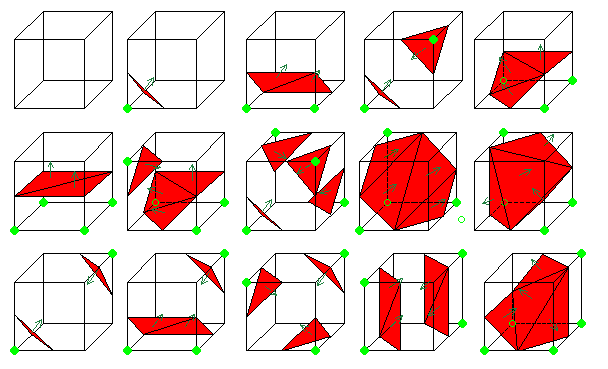

In [ ]:
def generate_img(time):
    render_poses = torch.unsqueeze(pose_spherical(180, -20, 4.0), 0).to(device)
    render_times = torch.Tensor([time]).to(device)

    with torch.no_grad():
            rgbs, _, _ = render_path(render_poses, render_times, hwf, args.chunk, render_kwargs_test, render_factor=args.render_factor)
    rgbs = to8b(rgbs)
    return rgbs[0]

_time = 1.  # time in [0,1]
img = generate_img(_time)

# display
plt.figure(2, figsize=(20,6))
plt.imshow(img)
plt.show()

N = 256
min_rec, max_rec = -1.2, 1.2
t = np.linspace(min_rec, max_rec, N+1)

query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
sh = query_pts.shape
pts = torch.Tensor(query_pts.reshape([-1,3]))

'''
def batchify_test(fn, chunk):
    if chunk is None:
        return fn
    def ret(inputs):
        return torch.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret
'''

def reconstruct(points, time):
    net_fn = render_kwargs_test['network_query_fn']
    fn = lambda i0, i1 : net_fn(points[i0:i1,None,:], viewdirs=torch.zeros_like(points[i0:i1]), ts=torch.ones_like(points[i0:i1])[:,0:1]*time, network_fn=render_kwargs_test['network_fn'])
    chunk = 1024*64
    raw = np.concatenate([fn(i, i+chunk)[0].cpu().numpy() for i in range(0, points.shape[0], chunk)], 0)
    raw = np.reshape(raw, list(sh[:-1]) + [-1])
    sigma = np.maximum(raw[...,-1], 0.)
    return sigma
    
with torch.no_grad():
    sigma = reconstruct(pts, _time)

In [ ]:
print(sigma.shape)
print(query_pts.shape)

In [ ]:
# reconstruct
threshold = 40  # this is just a randomly found threshold
vertices, triangles = mcubes.marching_cubes(sigma, threshold)

# display
mesh = trimesh.Trimesh(vertices / N * (max_rec - min_rec) + min_rec , triangles)
mesh = trimesh.smoothing.filter_laplacian(mesh, iterations=3)
mesh.show()

## Visualize Video Output

In [ ]:
args.no_reload = False
args.render_only = True
args.render_test = False
train(args)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
testsavedir = os.path.join(args.basedir, args.expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', 800000))

mp4 = open(os.path.join(testsavedir, 'video.mp4'),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Calculate Test Metrics
- MSE
- PSNR
- SSIM
- lpips

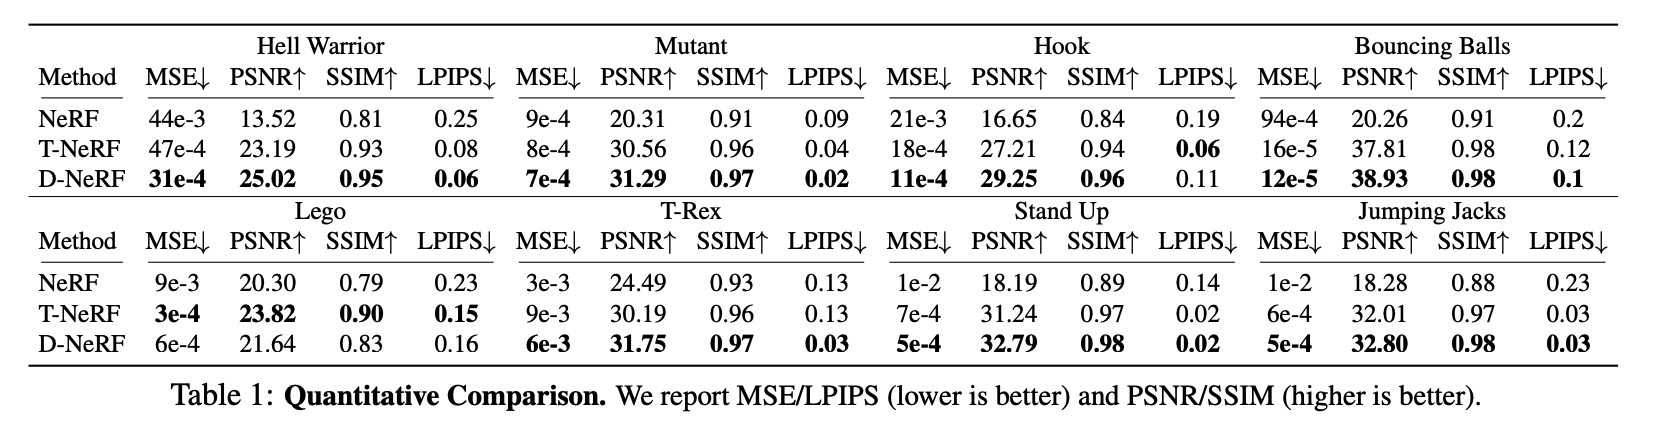

In [ ]:
# Mean Square Error
class MSE(object):
    def __call__(self, pred, gt):
        return torch.mean((pred - gt) ** 2)

# Peak Signal to Noise Ratio
class PSNR(object):
    def __call__(self, pred, gt):
        mse = torch.mean((pred - gt) ** 2)
        return 10 * torch.log10(1 / mse)

# structural similarity index
class SSIM(object):
    '''
    borrowed from https://github.com/huster-wgm/Pytorch-metrics/blob/master/metrics.py
    '''
    def gaussian(self, w_size, sigma):
        gauss = torch.Tensor([math.exp(-(x - w_size//2)**2/float(2*sigma**2)) for x in range(w_size)])
        return gauss/gauss.sum()

    def create_window(self, w_size, channel=1):
        _1D_window = self.gaussian(w_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, w_size, w_size).contiguous()
        return window

    def __call__(self, y_pred, y_true, w_size=11, size_average=True, full=False):
        """
        args:
            y_true : 4-d ndarray in [batch_size, channels, img_rows, img_cols]
            y_pred : 4-d ndarray in [batch_size, channels, img_rows, img_cols]
            w_size : int, default 11
            size_average : boolean, default True
            full : boolean, default False
        return ssim, larger the better
        """
        # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
        if torch.max(y_pred) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(y_pred) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val

        padd = 0
        (_, channel, height, width) = y_pred.size()
        window = self.create_window(w_size, channel=channel).to(y_pred.device)

        mu1 = F.conv2d(y_pred, window, padding=padd, groups=channel)
        mu2 = F.conv2d(y_true, window, padding=padd, groups=channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(y_pred * y_pred, window, padding=padd, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(y_true * y_true, window, padding=padd, groups=channel) - mu2_sq
        sigma12 = F.conv2d(y_pred * y_true, window, padding=padd, groups=channel) - mu1_mu2

        C1 = (0.01 * L) ** 2
        C2 = (0.03 * L) ** 2

        v1 = 2.0 * sigma12 + C2
        v2 = sigma1_sq + sigma2_sq + C2
        cs = torch.mean(v1 / v2)  # contrast sensitivity

        ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

        if size_average:
            ret = ssim_map.mean()
        else:
            ret = ssim_map.mean(1).mean(1).mean(1)

        if full:
            return ret, cs
        return ret
        
# Learned Perceptual Image Patch Similarity
class LPIPS(object):
    '''
    borrowed from https://github.com/huster-wgm/Pytorch-metrics/blob/master/metrics.py
    '''
    def __init__(self):
        self.model = lpips.LPIPS(net='vgg').cuda()

    def __call__(self, y_pred, y_true, normalized=True):
        """
        args:
            y_true : 4-d ndarray in [batch_size, channels, img_rows, img_cols]
            y_pred : 4-d ndarray in [batch_size, channels, img_rows, img_cols]
            normalized : change [0,1] => [-1,1] (default by LPIPS)
        return LPIPS, smaller the better
        """
        if normalized:
            y_pred = y_pred * 2.0 - 1.0
            y_true = y_true * 2.0 - 1.0
        error =  self.model.forward(y_pred, y_true)
        return torch.mean(error)

In [ ]:
def read_images_in_dir(imgs_dir):
    imgs = []
    fnames = os.listdir(imgs_dir)
    fnames.sort()
    for fname in fnames:
        if fname == "000.png" :  # ignore canonical space, only evalute real scene
            continue
            
        img_path = os.path.join(imgs_dir, fname)
        img = imageio.imread(img_path)
        img = (np.array(img) / 255.).astype(np.float32)
        img = np.transpose(img, (2, 0, 1))
        imgs.append(img)
    
    imgs = np.stack(imgs)       
    return imgs

def estim_error(estim, gt):
    errors = dict()
    metric = MSE()
    errors["mse"] = metric(estim, gt).item()
    metric = PSNR()
    errors["psnr"] = metric(estim, gt).item()
    metric = SSIM()
    errors["ssim"] = metric(estim, gt).item()
    metric = LPIPS()
    errors["lpips"] = metric(estim, gt).item()
    return errors

def save_error(errors, save_dir):
    save_path = os.path.join(save_dir, "metrics.txt")
    f = open(save_path,"w")
    f.write( str(errors) )
    f.close()

In [ ]:
# First, render test images
args.no_reload = False
args.render_only = True
args.render_test = True
train(args)

In [ ]:
files_dir = "./logs/mutant/renderonly_test_800000/"

estim_dir = os.path.join(files_dir, "estim")
gt_dir = os.path.join(files_dir, "gt")

estim = read_images_in_dir(estim_dir)
gt = read_images_in_dir(gt_dir)

estim = torch.Tensor(estim).cuda()
gt = torch.Tensor(gt).cuda()

errors = estim_error(estim, gt)
save_error(errors, files_dir)
print(errors)